# Twitter US Airline Sentiment Analysis

GitHub URL: https://github.com/kmprakashbabu/TwitterUSAirlineSentimentAnalysis

## 1. Import the libraries, load dataset, print shape of data, data description.

In [1]:
#Install contractions library
!pip install contractions

In [2]:
#upgrade scikit-learn verion to user imblearn
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\kvras\anaconda3\lib\site-packages (0.24.1)


In [3]:
#install mlxtend to draw confusion matrix
!pip install mlxtend

In [4]:
#import necessary libraries.

import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

#import natural language kit
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kvras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kvras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kvras\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#check sklearn version after upgrade
import sklearn
sklearn.__version__

'0.24.1'

In [6]:
#install imblearn to use SMOTE to handle class imblance problem
!pip install imblearn

In [7]:
#install delayed which is the dependency for imblearn
!pip install delayed

In [8]:
#import SMOTE
from imblearn.over_sampling import SMOTE

In [9]:
# Loading data into pandas dataframe
data = pd.read_csv("Tweets.csv")

In [10]:
data.shape

(14640, 15)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [12]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## 2.Understand of data-columns:
    a.Drop all other columns except “text”and “airline_sentiment”.
    b.Check the shape of data.
    c.Print first 5 rows of data.

In [13]:
# Let us now remove irrelevant columns
data = data.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count','tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis =1)

In [14]:
data.shape

(14640, 2)

In [15]:
data.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


# EDA
EDA is done to see if there is any class imbalance

In [16]:
print(data.airline_sentiment.value_counts())

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


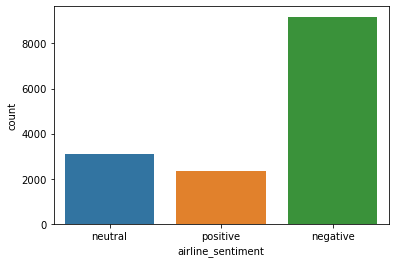

In [17]:
sns.countplot(data['airline_sentiment'])

## 3.Text pre-processing:Data preparation.
    a.Html tag removal.
    b.Tokenization.
    c.Remove the numbers.
    d.Removal of Special Characters and Punctuations.
    e.Conversion to lowercase.
    f.Lemmatize or stemming.
    g.Join the words in the list to convert back to text string in the dataframe. (So that each row contains the data in text format.)
    h.Print first 5 rows of data after pre-processing.

In [18]:
#Use BeautifulSoup to remove HTML tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [19]:
#User contractions to replace contractions in the text
def replace_contractions(text):
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


In [20]:
#Let's use regex to remove numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


In [21]:
#Let's tokenize the text
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
data.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, com..."
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, is, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, is, a, really, big..."


In [22]:
# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]


stopwords = list(set(stopwords) - set(customlist))  

In [23]:
#Remove non_ascii chars, puncutations, stopwords
#convert the text to lowercase to minimize the dimensions
#lemmatize the text

#init WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience ...
2,neutral,virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


## 4. Vectorization:
    a. Use CountVectorizer
    b. Use TfidfVectorizer

In [24]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

#use 5000 features
count_vectorizer = CountVectorizer(max_features=5000)                
count_v_data_features = count_vectorizer.fit_transform(data['text'])

count_v_data_features = count_v_data_features.toarray()
count_v_data_features.shape

(14640, 5000)

In [25]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_v_data_features = tfidf_vectorizer.fit_transform(data['text'])

tfidf_v_data_features = tfidf_v_data_features.toarray()

tfidf_v_data_features.shape

(14640, 5000)

## 5. Fit and evaluate model using both type of vectorization.

### 1. Random Forest Classifier on CountVectorizer

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


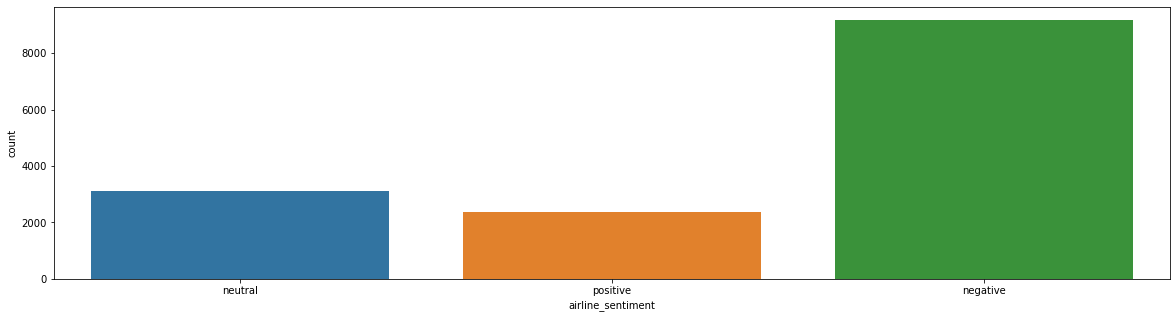

In [26]:
y = data['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)

In [27]:
#Split train and test data

x = count_v_data_features     # Predictor feature columns
y = data['airline_sentiment']   # Predicted class

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10248, 5000)
(10248,)
(4392, 5000)
(4392,)


In [28]:
#From the above diagram we can see that the airline_sentiment is not balanced
#Let's use SMOTE to make the classes balanced so that we get better prediction accuracy
smt = SMOTE(random_state=0)
x_train_SMOTE, y_train_SMOTE = smt.fit_resample(x_train, y_train)

print(x_train_SMOTE.shape)
print(y_train_SMOTE.shape)

(19311, 5000)
(19311,)


neutral     6437
positive    6437
negative    6437
Name: airline_sentiment, dtype: int64


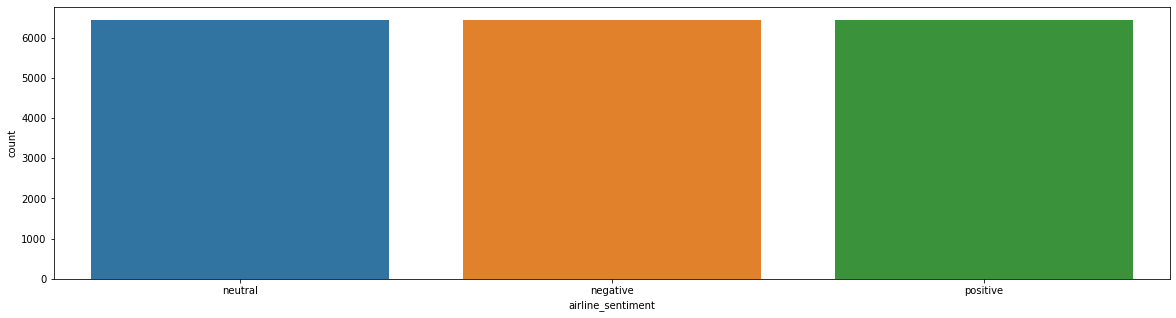

In [29]:
#Check and see if the imblance is resolved
after_smote_airline_sentiment=pd.DataFrame(y_train_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)

In [30]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(x_train_SMOTE, y_train_SMOTE)

print(forest)

print("Traning Score : ",forest.score(x_train_SMOTE, y_train_SMOTE))



RandomForestClassifier(n_estimators=10, n_jobs=4)
Traning Score :  0.8917715291802599


In [31]:
print(np.mean(cross_val_score(forest, x_train_SMOTE, y_train_SMOTE, cv=10)))

0.7463659288946929


In [32]:
print("Testing accuracy",forest.score(x_test, y_test))

Testing accuracy 0.7165300546448088


In [33]:
y_test_predict= forest.predict(x_test)

print(metrics.classification_report(y_test,y_test_predict))

              precision    recall  f1-score   support

    negative       0.84      0.81      0.82      2741
     neutral       0.49      0.54      0.51       936
    positive       0.59      0.57      0.58       715

    accuracy                           0.72      4392
   macro avg       0.64      0.64      0.64      4392
weighted avg       0.72      0.72      0.72      4392



<Figure size 432x288 with 0 Axes>

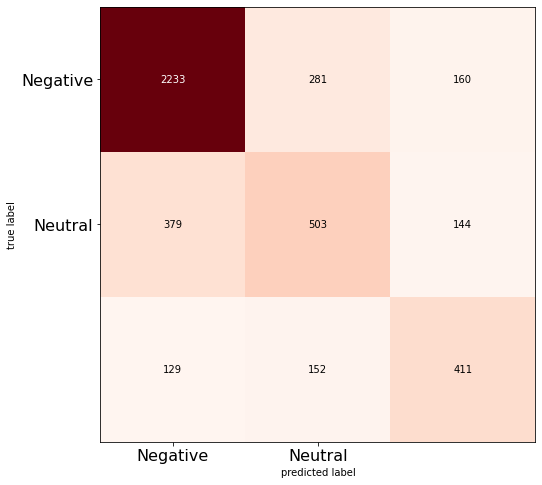

In [34]:
#draw confusion matrix
cm=confusion_matrix(y_test_predict , y_test)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

### 2. Random Forest Classifier on TfidfVectorizer

In [35]:
#Split train and test data

x_tf_idf = tfidf_v_data_features     # Predictor feature columns
y_tf_idf = data['airline_sentiment']   # Predicted class

x_train_tf_idf, x_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(x_tf_idf, y_tf_idf, test_size=0.3, random_state=1)  

print(x_train_tf_idf.shape)
print(y_train_tf_idf.shape)
print(x_test_tf_idf.shape)
print(y_test_tf_idf.shape)


(10248, 5000)
(10248,)
(4392, 5000)
(4392,)


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


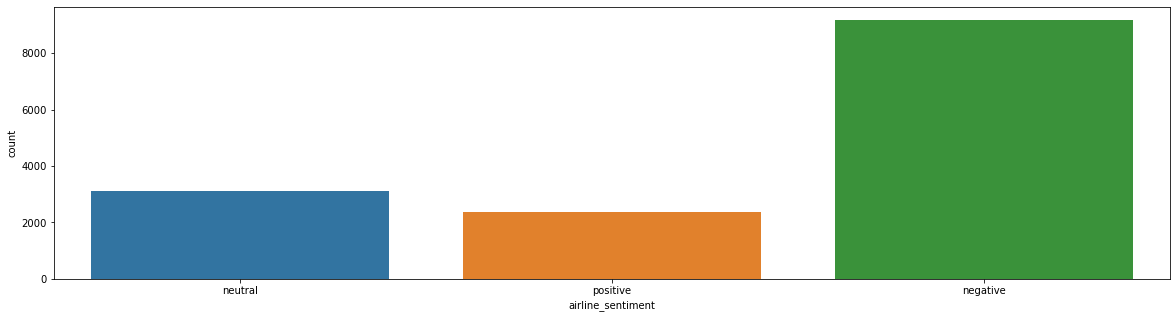

In [36]:
y = data['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5)) 
g = sns.countplot(y)

In [39]:
tf_idf_smt = SMOTE(random_state=0)
x_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE = smt.fit_resample(x_train_tf_idf, y_train_tf_idf)
print(x_train_tf_idf_SMOTE.shape)
print(y_train_tf_idf_SMOTE.shape)

(19311, 5000)
(19311,)


neutral     6437
positive    6437
negative    6437
Name: airline_sentiment, dtype: int64


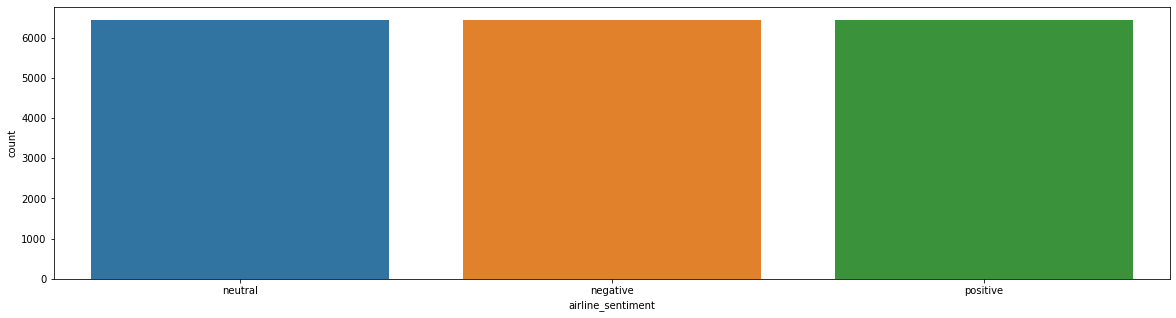

In [40]:
after_smote_airline_sentiment_tf_idf=pd.DataFrame(y_train_tf_idf_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment_tf_idf['airline_sentiment']
print(y.value_counts())
plt.figure(figsize=(20,5))
g = sns.countplot(y)

In [41]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

forest_tfidf = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest_tfidf = forest.fit(x_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

print(forest_tfidf)

print(forest_tfidf.score(x_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.9913520791258869


In [42]:
print(np.mean(cross_val_score(forest_tfidf, x_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE, cv=10)))

0.8751549310422838


In [45]:
print("Testing accuracy",forest_tfidf.score(x_test_tf_idf, y_test_tf_idf))

Testing accuracy 0.7493169398907104


In [46]:
y_test_tf_idf_predict= forest.predict(x_test_tf_idf)

print(metrics.classification_report(y_test_tf_idf,y_test_tf_idf_predict))

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84      2741
     neutral       0.55      0.51      0.53       936
    positive       0.71      0.58      0.64       715

    accuracy                           0.75      4392
   macro avg       0.69      0.66      0.67      4392
weighted avg       0.74      0.75      0.74      4392



<Figure size 432x288 with 0 Axes>

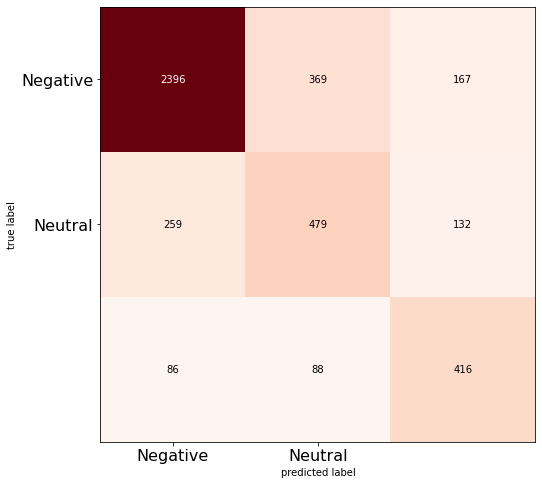

In [47]:
#draw confusion matrix

cm=confusion_matrix(y_test_tf_idf_predict , y_test_tf_idf)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
plt.xticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
plt.yticks(range(2), ['Negative', 'Neutral', 'Positive'], fontsize=16)
plt.show()

### 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your modelon this dataset.

1. It is very important to pre-process the data in nlp because we will easily introduce curse of dimensionality. And machine will learn words which have no meaning at all in a given context. It will take time for the machine to process as it learns more number of features and accuary will suffer. In order to make the data clean and feed it to the machine following pre-processing techniques are applied which would remove irrelevent texts like numbers, special characters, HTML tags etc. Also a custom stop words set is created so that the context of the sentence is not lost or interpreted/classifed wrongly.
    a. Html tag removal.
    b. Tokenization.
    c. Remove the numbers.
    d. Contractions
    d. Removal of Special Characters and Punctuations.
    e. Conversion to lowercase.
    f. Lemmatize or stemming
    
2. From the count plot it is evident that we have class imbalance problem. So SMOTE is applied to bring the classes in balance
3. 2 Vectorization techinques applied
    a. Count Vectorization
    b. TFIDF Vectorization
4. Count Vectorization accuracy score is 71% and TFIDF Vectorization accuary score is 74%
5. Though not much difference, TFIDF has performed a bit well compared to CountVectorization
6. Used RandomForestClassifer for the sentiment analysis